##Feature Engineering Code
We have added in the following features to the data:
1. Number of Holidays in the Month
2. Housing Amenities
3. Topics in Listing Summary
4. Review Sentiment
5. Distance from Popular Tourist Attractions

#Load Pre-Processed Data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np

In [0]:
pathlistings = '/content/gdrive/My Drive/BT4222 project/Feature Engineering Data/afterpreprocessing.csv'
df = pd.read_csv(pathlistings)
len(df)

99994

In [0]:
df.head()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,calendar_last_scraped,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,id,instant_bookable,is_business_travel_ready,last_scraped,latitude,longitude,maximum_nights,minimum_nights,neighbourhood,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,review_scores_rating,room_type
0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",144.0,2.0,Real Bed,3.0,4.0,2018-10-03,strict_14_with_grace_period,100.0,come enjoy 3 bedroom 2 bathroom,0.0,1.0,1,0,0,1.0,6,28440971.0,1,0,2018-10-03,40.726923,-73.981020,1125.0,2.0,Alphabet City,2.0,475.0,Apartment,0,0,100.0,Entire home/apt
1,2.0,"{Wifi,""Air conditioning"",Kitchen,""Indoor firep...",0.0,1.0,Real Bed,1.0,1.0,2019-12-05,moderate,40.0,beautifully renovated entire brownstone brookl...,20.0,1.0,1,1,0,2.0,5,21799470.0,0,0,2019-12-05,40.685070,-73.935650,21.0,1.0,Bedford-Stuyvesant,1.0,60.0,House,0,0,100.0,Private room
2,2.0,"{Wifi,Kitchen,Heating,Shampoo,""Lock on bedroom...",0.0,1.0,Real Bed,1.0,1.0,2018-04-07,flexible,NaN,10 minute walk fort greene park lot natural su...,0.0,1.0,1,0,0,2.0,7,16406203.0,1,0,2018-04-07,40.696133,-73.973640,7.0,3.0,Brooklyn Navy Yard,0.0,80.0,Apartment,0,0,NaN,Private room
3,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",16.0,1.0,Real Bed,1.0,3.0,2018-02-03,strict,NaN,make home beautiful 600sq feet 60 sq meter bed...,10.0,2.0,1,0,0,1.0,7,19554150.0,0,0,2018-02-03,40.705261,-74.010263,1125.0,3.0,Financial District,18.0,225.0,Apartment,0,0,86.0,Entire home/apt
4,6.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",0.0,2.0,Real Bed,3.0,3.0,2019-10-14,strict_14_with_grace_period,100.0,south slope brooklyn 3br 2 bath condo availabl...,0.0,1.0,1,0,0,1.0,8,25801507.0,1,0,2019-10-14,40.661320,-73.991920,31.0,3.0,Greenwood Heights,6.0,280.0,Condominium,0,0,100.0,Entire home/apt


#Feature Engineering 1: Number of holidays in the month
Listing prices are likely to be affected by fluctuations in demand, which is usually higher during holiday season (e.g. Christmas). Hence, we added in number of holidays in the month as a feature to take into account seasonal fluctuations in demand.

In [0]:
# change the date format
df['calendar_last_scraped'] = df['calendar_last_scraped'].map(lambda x: list(str(x).split('-')))

In [0]:
# add number of holidays in each month
count=0
df['noofholidays']=0
for row in df.calendar_last_scraped:
  if row[1]=='01':
    df.at[count, 'noofholidays'] = 6
  elif row[1]=='02':
    df.at[count, 'noofholidays'] = 1
  elif row[1]=='05':
    df.at[count, 'noofholidays'] = 1
  elif row[1]=='06':
    df.at[count, 'noofholidays'] = 0
  elif row[1]=='07':
    df.at[count, 'noofholidays'] = 1
  elif row[1]=='09':
    df.at[count, 'noofholidays'] = 1
  elif row[1]=='10':
    df.at[count, 'noofholidays'] = 1
  elif row[1]=='11':
    df.at[count, 'noofholidays'] = 2
  elif row[1]=='12':
    df.at[count, 'noofholidays'] = 7
  count+=1

df.noofholidays

0        1
1        7
2        0
3        1
4        1
        ..
99989    1
99990    1
99991    0
99992    1
99993    7
Name: noofholidays, Length: 99994, dtype: int64

In [0]:
df.head()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,calendar_last_scraped,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,id,instant_bookable,is_business_travel_ready,last_scraped,latitude,longitude,maximum_nights,minimum_nights,neighbourhood,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,review_scores_rating,room_type,noofholidays
0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",144.0,2.0,Real Bed,3.0,4.0,"[2018, 10, 03]",strict_14_with_grace_period,100.0,come enjoy 3 bedroom 2 bathroom,0.0,1.0,1,0,0,1.0,6,28440971.0,1,0,2018-10-03,40.726923,-73.981020,1125.0,2.0,Alphabet City,2.0,475.0,Apartment,0,0,100.0,Entire home/apt,1
1,2.0,"{Wifi,""Air conditioning"",Kitchen,""Indoor firep...",0.0,1.0,Real Bed,1.0,1.0,"[2019, 12, 05]",moderate,40.0,beautifully renovated entire brownstone brookl...,20.0,1.0,1,1,0,2.0,5,21799470.0,0,0,2019-12-05,40.685070,-73.935650,21.0,1.0,Bedford-Stuyvesant,1.0,60.0,House,0,0,100.0,Private room,7
2,2.0,"{Wifi,Kitchen,Heating,Shampoo,""Lock on bedroom...",0.0,1.0,Real Bed,1.0,1.0,"[2018, 04, 07]",flexible,NaN,10 minute walk fort greene park lot natural su...,0.0,1.0,1,0,0,2.0,7,16406203.0,1,0,2018-04-07,40.696133,-73.973640,7.0,3.0,Brooklyn Navy Yard,0.0,80.0,Apartment,0,0,NaN,Private room,0
3,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",16.0,1.0,Real Bed,1.0,3.0,"[2018, 02, 03]",strict,NaN,make home beautiful 600sq feet 60 sq meter bed...,10.0,2.0,1,0,0,1.0,7,19554150.0,0,0,2018-02-03,40.705261,-74.010263,1125.0,3.0,Financial District,18.0,225.0,Apartment,0,0,86.0,Entire home/apt,1
4,6.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",0.0,2.0,Real Bed,3.0,3.0,"[2019, 10, 14]",strict_14_with_grace_period,100.0,south slope brooklyn 3br 2 bath condo availabl...,0.0,1.0,1,0,0,1.0,8,25801507.0,1,0,2019-10-14,40.661320,-73.991920,31.0,3.0,Greenwood Heights,6.0,280.0,Condominium,0,0,100.0,Entire home/apt,1


#Feature Engineering 2: Housing Amenities
Certain amenities in the house such as sofa, TV may enhance customer satisfaction, hence they may be willing to pay a higher price.

Text(0.5, 0, 'Count')

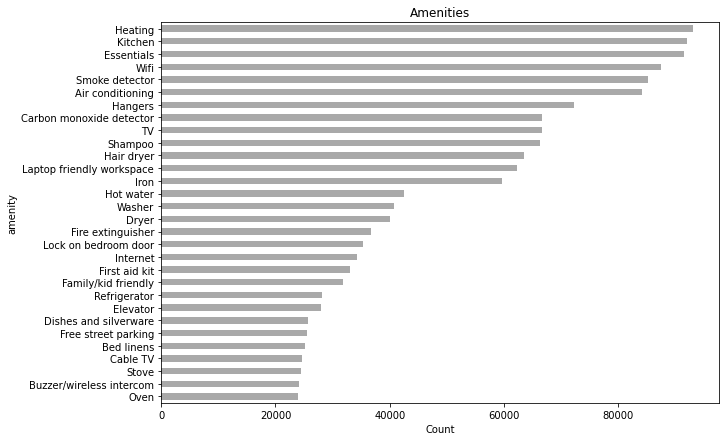

In [0]:
# plot the top 30 amenities provided by the accommodation
from collections import Counter
results = Counter()
df['amenities'].str.strip('{}').str.replace('"', '').str.lstrip('\"').str.rstrip('\"').str.split(',').apply(results.update)

import matplotlib.pyplot as plt
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',figsize=(10,7), legend=False, color='darkgrey',title='Amenities')
plt.xlabel('Count')

In [0]:
# select important amenitites
df['Kitchen'] = df['amenities'].str.contains('Kitchen')
df['TV'] = df['amenities'].str.contains('TV')
df['Shampoo'] = df['amenities'].str.contains('Shampoo')
df['Hair_dryer'] = df['amenities'].str.contains('Hair dryer')
df['Iron'] = df['amenities'].str.contains('Iron')
df['Washer'] = df['amenities'].str.contains('Washer')
df['Lock_on_bedroom_door'] = df['amenities'].str.contains('Lock on bedroom door')
df['Free_street_parking'] = df['amenities'].str.contains('Free street parking')
df['Microwave'] = df['amenities'].str.contains('Microwave')
df['Cooking_basics'] = df['amenities'].str.contains('Cooking basics')

# encode true/false to 1/0
import numpy as np
df.Hair_dryer = np.where(df.Hair_dryer == True, 1, 0)
df.TV = np.where(df.TV == True, 1, 0)
df.Washer = np.where(df.Washer == True, 1, 0)
df.Microwave = np.where(df.Microwave == True, 1, 0)
df.Shampoo = np.where(df.Shampoo == True, 1, 0)
df.Free_street_parking = np.where(df.Free_street_parking == True, 1, 0)
df.Cooking_basics = np.where(df.Cooking_basics == True, 1, 0)
df.Kitchen = np.where(df.Kitchen == True, 1, 0)
df.Iron = np.where(df.Iron == True, 1, 0)
df.Lock_on_bedroom_door = np.where(df.Lock_on_bedroom_door == True, 1, 0)

In [0]:
df.head()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,calendar_last_scraped,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,id,instant_bookable,is_business_travel_ready,last_scraped,latitude,longitude,maximum_nights,minimum_nights,neighbourhood,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,review_scores_rating,room_type,noofholidays,Hair_dryer,TV,Washer,Microwave,Shampoo,Free_street_parking,Cooking_basics,Kitchen,Iron,Lock_on_bedroom_door,desc_location,desc_facility,listing_id,sentiment_min,sentiment_max,sentiment_avg,has_sentiment,Air_conditioning,Laptop_friendly_workspace,Hot_water,Dryer,Family_kid_friendly,Refrigerator,Elevator
0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",144.0,2.0,Real Bed,3.0,4.0,"[2018, 10, 03]",strict_14_with_grace_period,100.0,come enjoy 3 bedroom 2 bathroom,0.0,1.0,1,0,0,1.0,6,28440971,1,0,2018-10-03,40.726923,-73.981020,1125.0,2.0,Alphabet City,2.0,475.0,Apartment,0,0,100.0,Entire home/apt,1,1,1,1,0,1,0,0,1,1,0,0,1,NaN,0.000000,0.800000,0.380403,0,1,0,0,1,0,0,0
1,2.0,"{Wifi,""Air conditioning"",Kitchen,""Indoor firep...",0.0,1.0,Real Bed,1.0,1.0,"[2019, 12, 05]",moderate,40.0,beautifully renovated entire brownstone brookl...,20.0,1.0,1,1,0,2.0,5,21799470,0,0,2019-12-05,40.685070,-73.935650,21.0,1.0,Bedford-Stuyvesant,1.0,60.0,House,0,0,100.0,Private room,7,1,0,1,0,1,0,0,1,0,0,2,3,21799470,0.544722,0.544722,0.544722,1,1,1,0,1,0,0,0
2,2.0,"{Wifi,Kitchen,Heating,Shampoo,""Lock on bedroom...",0.0,1.0,Real Bed,1.0,1.0,"[2018, 04, 07]",flexible,NaN,10 minute walk fort greene park lot natural su...,0.0,1.0,1,0,0,2.0,7,16406203,1,0,2018-04-07,40.696133,-73.973640,7.0,3.0,Brooklyn Navy Yard,0.0,80.0,Apartment,0,0,NaN,Private room,0,1,0,0,0,1,0,0,1,0,1,7,3,NaN,0.000000,0.800000,0.380403,0,0,0,0,0,0,0,0
3,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",16.0,1.0,Real Bed,1.0,3.0,"[2018, 02, 03]",strict,NaN,make home beautiful 600sq feet 60 sq meter bed...,10.0,2.0,1,0,0,1.0,7,19554150,0,0,2018-02-03,40.705261,-74.010263,1125.0,3.0,Financial District,18.0,225.0,Apartment,0,0,86.0,Entire home/apt,1,1,1,1,1,1,0,1,1,1,0,6,3,NaN,0.000000,0.800000,0.380403,0,1,1,1,1,1,1,1
4,6.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",0.0,2.0,Real Bed,3.0,3.0,"[2019, 10, 14]",strict_14_with_grace_period,100.0,south slope brooklyn 3br 2 bath condo availabl...,0.0,1.0,1,0,0,1.0,8,25801507,1,0,2019-10-14,40.661320,-73.991920,31.0,3.0,Greenwood Heights,6.0,280.0,Condominium,0,0,100.0,Entire home/apt,1,1,1,1,0,0,0,0,1,0,1,1,4,25801507,0.167937,0.737500,0.413909,1,1,1,0,1,0,0,1


#Feature Engineering 3: Topics in Listing Description
Instead of using the raw description texts, we decided to extract out the important topics from the description.

In [0]:
# removing stopwords, punctuations and normalizing the corpus
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
stop.add("apartment")
stop.add("nyc")
stop.add("place")
stop.add("area")
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([word for word in doc.split() if word not in stop])
    punc_free = "".join(token for token in stop_free if token not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
    return normalized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# df['description'] = df['description'].apply(str)
# desc = df['description'].tolist()
# doc_clean = [d.split() for d in desc]

# import gensim
# from gensim import corpora
# dictionary = corpora.Dictionary(doc_clean)
# corpus = [dictionary.doc2bow(text) for text in doc_clean]
# # let LDA find 5 topics
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# # uncomment the code if working locally
# #ldamodel.save('../input/sentimentData/model3.gensim')

# topics = ldamodel.print_topics(num_words=10)
# for topic in topics:
#     print(topic)

# #df_listings.description = doc_clean

In [0]:
# #explore two topics
# dictionary = corpora.Dictionary(doc_clean)
# corpus = [dictionary.doc2bow(text) for text in doc_clean]
# # let LDA find 5 topics
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word=dictionary, passes=15)
# topics = ldamodel.print_topics(num_words=10)
# for topic in topics:
#     print(topic)

(0, '0.014*"kitchen" + 0.014*"bedroom" + 0.013*"bed" + 0.010*"living" + 0.009*"full" + 0.008*"space" + 0.008*"private" + 0.008*"bathroom" + 0.007*"new" + 0.007*"large"')
(1, '0.012*"restaurants" + 0.012*"walk" + 0.011*"away" + 0.011*"train" + 0.011*"park" + 0.010*"subway" + 0.010*"manhattan" + 0.008*"neighborhood" + 0.008*"2" + 0.008*"minutes"')


In [0]:
# extract 2 important topics from description 
location_words=["min","minute","manhattan","park","train","subway","away","restaurant","walk","located","bar","beach"]
facility_words=["room","bed","bedroom","kithen","bathroom","private","large","spacious","luxury","queen","king","whole"]

# count the number of occurrences of words in each topic
def countOccurences(content, word):      
    a = content.split(" ") 
    count = 0
    for i in range(0,len(a)-1):          
        # if match, increase count by 1
        if (word == a[i]): 
           count = count + 1       
    return count   

def countOccurrences2(str,words):
  res=0
  for word in words:
    res+=countOccurences(str,word)
  return res

df['description'] = df['description'].apply(str)
df['desc_location']=df['description'].apply(lambda x: countOccurrences2(x,location_words))
df['desc_facility']=df['description'].apply(lambda x: countOccurrences2(x,facility_words))

In [0]:
df.head()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,calendar_last_scraped,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,id,instant_bookable,is_business_travel_ready,last_scraped,latitude,longitude,maximum_nights,minimum_nights,neighbourhood,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,review_scores_rating,room_type,noofholidays,Hair_dryer,TV,Washer,Microwave,Shampoo,Free_street_parking,Cooking_basics,Kitchen,Iron,Lock_on_bedroom_door,desc_location,desc_facility
0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",144.0,2.0,Real Bed,3.0,4.0,"[2018, 10, 03]",strict_14_with_grace_period,100.0,come enjoy 3 bedroom 2 bathroom,0.0,1.0,1,0,0,1.0,6,28440971.0,1,0,2018-10-03,40.726923,-73.981020,1125.0,2.0,Alphabet City,2.0,475.0,Apartment,0,0,100.0,Entire home/apt,1,0,1,1,0,1,0,0,1,1,0,0,1
1,2.0,"{Wifi,""Air conditioning"",Kitchen,""Indoor firep...",0.0,1.0,Real Bed,1.0,1.0,"[2019, 12, 05]",moderate,40.0,beautifully renovated entire brownstone brookl...,20.0,1.0,1,1,0,2.0,5,21799470.0,0,0,2019-12-05,40.685070,-73.935650,21.0,1.0,Bedford-Stuyvesant,1.0,60.0,House,0,0,100.0,Private room,7,0,0,1,0,1,0,0,1,0,0,2,3
2,2.0,"{Wifi,Kitchen,Heating,Shampoo,""Lock on bedroom...",0.0,1.0,Real Bed,1.0,1.0,"[2018, 04, 07]",flexible,NaN,10 minute walk fort greene park lot natural su...,0.0,1.0,1,0,0,2.0,7,16406203.0,1,0,2018-04-07,40.696133,-73.973640,7.0,3.0,Brooklyn Navy Yard,0.0,80.0,Apartment,0,0,NaN,Private room,0,0,0,0,0,1,0,0,1,0,1,7,3
3,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",16.0,1.0,Real Bed,1.0,3.0,"[2018, 02, 03]",strict,NaN,make home beautiful 600sq feet 60 sq meter bed...,10.0,2.0,1,0,0,1.0,7,19554150.0,0,0,2018-02-03,40.705261,-74.010263,1125.0,3.0,Financial District,18.0,225.0,Apartment,0,0,86.0,Entire home/apt,1,0,1,1,1,1,0,1,1,1,0,6,3
4,6.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",0.0,2.0,Real Bed,3.0,3.0,"[2019, 10, 14]",strict_14_with_grace_period,100.0,south slope brooklyn 3br 2 bath condo availabl...,0.0,1.0,1,0,0,1.0,8,25801507.0,1,0,2019-10-14,40.661320,-73.991920,31.0,3.0,Greenwood Heights,6.0,280.0,Condominium,0,0,100.0,Entire home/apt,1,0,1,1,0,0,0,0,1,0,1,1,4


#Feature Engineering 4: Review Sentiment
Sentiment of review may indicate how attractive a house is, hence the amount of money people are willing to pay for it.

In [0]:
# #### WARNING: this cell is very low

# # read reviews into dastaframe
# pathreviews = '/content/gdrive/My Drive/BT4222 project/100K Samples Data/10klistings_2yrs_reviews.csv'
# df_reviews = pd.read_csv(pathreviews)
# df_reviews.head()

# # function to calculate sentiment score for a review
# from textblob import TextBlob
# def detect_sentiment(text):
#     blob = TextBlob(text)
#     return blob.sentiment.polarity

# # calculate sentiment score for each review
# df_reviews['comments'] = df_reviews['comments'].map(str)
# df_reviews['sentiment'] = df_reviews['comments'].apply(detect_sentiment)

# # calculate minimum/maximum/average sentiment scores for each listing
# sentiment_min = df_reviews.groupby(by='listing_id')['sentiment'].min()
# sentiment_max = df_reviews.groupby(by='listing_id')['sentiment'].max()
# sentiment_avg = df_reviews.groupby(by='listing_id')['sentiment'].mean()
# listing_sentiment = pd.DataFrame({"sentiment_min": sentiment_min, "sentiment_max": sentiment_max, "sentiment_avg": sentiment_avg})
# listing_sentiment = listing_sentiment.reset_index()

# # output to csv file
# listing_sentiment.to_csv('/content/gdrive/My Drive/BT4222 project/Feature Engineering Data/listing_sentiment.csv', index = False)

In [0]:
# read sentiment scores from csv file
df_sentiment = pd.read_csv("/content/gdrive/My Drive/BT4222 project/Feature Engineering Data/listing_sentiment.csv")

# align ID data type for listing and sentiment dataframes
df_sentiment.listing_id = df_sentiment.listing_id.astype('str')
df.loc[:,'id'] = df.id.astype('str')
df.loc[:,'id'] = df.id.str.split(".").apply(lambda x: x[0])

# merge listing dataframe with sentiment dataframe
df = df.merge(df_sentiment, left_on='id', right_on='listing_id',how='left')

# fill NA
df.sentiment_avg = df.sentiment_avg.fillna(df.sentiment_avg.median())
df.sentiment_min = df.sentiment_min.fillna(df.sentiment_min.median())
df.sentiment_max = df.sentiment_max.fillna(df.sentiment_max.median())

# label whether listing has sentiment score for reviews
df.loc[:,'has_sentiment'] = np.where(df.listing_id.isna(), 0 ,1)

In [0]:
df.head()

,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,calendar_last_scraped,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,id,instant_bookable,is_business_travel_ready,last_scraped,latitude,longitude,maximum_nights,minimum_nights,neighbourhood,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,review_scores_rating,room_type,noofholidays,Hair_dryer,TV,Washer,Microwave,Shampoo,Free_street_parking,Cooking_basics,Kitchen,Iron,Lock_on_bedroom_door,desc_location,desc_facility,listing_id,sentiment_min,sentiment_max,sentiment_avg,has_sentiment
0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",144.0,2.0,Real Bed,3.0,4.0,"[2018, 10, 03]",strict_14_with_grace_period,100.0,come enjoy 3 bedroom 2 bathroom,0.0,1.0,1,0,0,1.0,6,28440971,1,0,2018-10-03,40.726923,-73.981020,1125.0,2.0,Alphabet City,2.0,475.0,Apartment,0,0,100.0,Entire home/apt,1,0,1,1,0,1,0,0,1,1,0,0,1,NaN,0.000000,0.800000,0.380403,0
1,2.0,"{Wifi,""Air conditioning"",Kitchen,""Indoor firep...",0.0,1.0,Real Bed,1.0,1.0,"[2019, 12, 05]",moderate,40.0,beautifully renovated entire brownstone brookl...,20.0,1.0,1,1,0,2.0,5,21799470,0,0,2019-12-05,40.685070,-73.935650,21.0,1.0,Bedford-Stuyvesant,1.0,60.0,House,0,0,100.0,Private room,7,0,0,1,0,1,0,0,1,0,0,2,3,21799470,0.544722,0.544722,0.544722,1
2,2.0,"{Wifi,Kitchen,Heating,Shampoo,""Lock on bedroom...",0.0,1.0,Real Bed,1.0,1.0,"[2018, 04, 07]",flexible,NaN,10 minute walk fort greene park lot natural su...,0.0,1.0,1,0,0,2.0,7,16406203,1,0,2018-04-07,40.696133,-73.973640,7.0,3.0,Brooklyn Navy Yard,0.0,80.0,Apartment,0,0,NaN,Private room,0,0,0,0,0,1,0,0,1,0,1,7,3,NaN,0.000000,0.800000,0.380403,0
3,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",16.0,1.0,Real Bed,1.0,3.0,"[2018, 02, 03]",strict,NaN,make home beautiful 600sq feet 60 sq meter bed...,10.0,2.0,1,0,0,1.0,7,19554150,0,0,2018-02-03,40.705261,-74.010263,1125.0,3.0,Financial District,18.0,225.0,Apartment,0,0,86.0,Entire home/apt,1,0,1,1,1,1,0,1,1,1,0,6,3,NaN,0.000000,0.800000,0.380403,0
4,6.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",0.0,2.0,Real Bed,3.0,3.0,"[2019, 10, 14]",strict_14_with_grace_period,100.0,south slope brooklyn 3br 2 bath condo availabl...,0.0,1.0,1,0,0,1.0,8,25801507,1,0,2019-10-14,40.661320,-73.991920,31.0,3.0,Greenwood Heights,6.0,280.0,Condominium,0,0,100.0,Entire home/apt,1,0,1,1,0,0,0,0,1,0,1,1,4,25801507,0.167937,0.737500,0.413909,1


#Feature Engineering 5: Distance from Popular Tourist Attractions
Location is known to be a prime factor in affecting housing prices. Tourists may find it convenient to live near tourist attraction, hence probably willing to pay a higher price for it.

In [0]:
# create a temporary dataframe containing location information
df_temp = df[['id','longitude','latitude']]
df_temp = df_temp.apply (pd.to_numeric, errors='coerce')
df_temp = df_temp.dropna()
df_temp.head()

,id,longitude,latitude
0,28440971.0,-73.981020,40.726923
1,21799470.0,-73.935650,40.685070
2,16406203.0,-73.973640,40.696133
3,19554150.0,-74.010263,40.705261
4,25801507.0,-73.991920,40.661320


In [0]:
# read location of top tourist attractions in New York
path1 = '/content/gdrive/My Drive/BT4222 project/Feature Engineering Data/attractions.xlsx'
attractions = pd.read_excel(path1)
attractions.head()

,name,longitude,latitude,visitor
0,Central Park,-73.9653,40.782222,42.0
1,Times Square,-73.986,40.757000,39.5
2,Grand Central Terminal,-73.9772,40.752813,21.6
3,Theater District,-73.985,40.759000,13.0
4,Rockefeller Centre,-73.9792,40.758611,12.8


In [0]:
# function to calculate distance between two locations
from geopy.distance import great_circle
def distance_to_point(lat, lon, lat_point, lon_point):
    point = (lat_point, lon_point)
    accommodation = (lat, lon)
    return great_circle(point, accommodation).km

In [0]:
# calculate distance from the accommodation to the attractions
for a in range(0,19):
  lon_point = attractions.iloc[a]['longitude']
  lat_point = attractions.iloc[a]['latitude']
  name = attractions.iloc[a]['name']
  df_temp[name] = df_temp.apply(lambda x: distance_to_point(x.latitude, x.longitude, lat_point, lon_point), axis=1)

In [0]:
# calculate the number of tourist attractions within 1km/2km of the accommodation
df_temp['within_1km'] = df_temp.iloc[:,3:21].le(1,axis = 0).sum(axis = 1)
df_temp['within_2km'] = df_temp.iloc[:,3:21].le(2,axis = 0).sum(axis = 1)

In [0]:
df_temp.head()

,id,Central Park,Times Square,Grand Central Terminal,Theater District,Rockefeller Centre,Bryant Park,Prospect Park,South Street Seaport,High Line,Coney Island,National 911 Memorial,Metropolitan Museum of Art,Rockaway Beach,American Museum of Natural History,Statue of Liberty,Empire State Building,National 911 Museum,Museum of Modern Art,One World Trade Centre,within_1km,within_2km
0,28440971.0,6.290352,3.370646,2.896662,3.582550,3.527032,3.021299,7.306778,2.981886,3.080815,17.006171,3.228241,6.027293,21.185678,5.987302,6.372342,2.411184,3.161735,3.866688,3.149798,0,0
1,21799470.0,11.087517,9.054114,8.307356,9.212780,8.962088,8.680486,3.946629,6.167145,9.104113,12.857144,7.207090,10.741018,15.173004,11.116263,9.112143,8.196074,7.115943,9.214852,7.271771,0,0
2,16406203.0,9.598588,6.847807,6.309758,7.055763,6.962864,6.493505,3.839729,2.737979,6.335120,13.585547,3.786344,9.301395,18.329670,9.387890,5.856323,5.890632,3.696358,7.287277,3.859221,0,0
3,19554150.0,9.359295,6.105582,5.976040,6.343340,6.485131,5.853955,5.878091,0.591749,4.774123,14.847273,0.766183,9.151463,21.346301,8.891733,3.027238,5.222351,0.718512,6.842493,0.911551,3,3
4,25801507.0,13.629902,10.650841,10.248802,10.877186,10.871553,10.327161,1.779097,5.072663,9.698244,9.780382,5.889518,13.352669,17.341317,13.337440,5.651166,9.690278,5.843060,11.215776,6.036516,0,1


In [0]:
# contatenate the new features to the dataframe
final = pd.concat([df_temp, df], axis=1).reindex(df.index)
final.head()

,id,Central Park,Times Square,Grand Central Terminal,Theater District,Rockefeller Centre,Bryant Park,Prospect Park,South Street Seaport,High Line,Coney Island,National 911 Memorial,Metropolitan Museum of Art,Rockaway Beach,American Museum of Natural History,Statue of Liberty,Empire State Building,National 911 Museum,Museum of Modern Art,One World Trade Centre,within_1km,within_2km,accommodates,amenities,availability_365,bathrooms,bed_type,bedrooms,beds,calendar_last_scraped,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,...,instant_bookable,is_business_travel_ready,last_scraped,latitude,longitude,maximum_nights,minimum_nights,neighbourhood,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,review_scores_rating,room_type,noofholidays,Hair_dryer,TV,Washer,Microwave,Shampoo,Free_street_parking,Cooking_basics,Kitchen,Iron,Lock_on_bedroom_door,desc_location,desc_facility,listing_id,sentiment_min,sentiment_max,sentiment_avg,has_sentiment,Air_conditioning,Laptop_friendly_workspace,Hot_water,Dryer,Family_kid_friendly,Refrigerator,Elevator
0,28440971.0,6.290352,3.370646,2.896662,3.582550,3.527032,3.021299,7.306778,2.981886,3.080815,17.006171,3.228241,6.027293,21.185678,5.987302,6.372342,2.411184,3.161735,3.866688,3.149798,0.0,0.0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",144.0,2.0,Real Bed,3.0,4.0,"[2018, 10, 03]",strict_14_with_grace_period,100.0,come enjoy 3 bedroom 2 bathroom,0.0,1.0,1,0,0,1.0,6,...,1,0,2018-10-03,40.726923,-73.981020,1125.0,2.0,Alphabet City,2.0,475.0,Apartment,0,0,100.0,Entire home/apt,1,1,1,1,0,1,0,0,1,1,0,0,1,NaN,0.000000,0.800000,0.380403,0,1,0,0,1,0,0,0
1,21799470.0,11.087517,9.054114,8.307356,9.212780,8.962088,8.680486,3.946629,6.167145,9.104113,12.857144,7.207090,10.741018,15.173004,11.116263,9.112143,8.196074,7.115943,9.214852,7.271771,0.0,0.0,2.0,"{Wifi,""Air conditioning"",Kitchen,""Indoor firep...",0.0,1.0,Real Bed,1.0,1.0,"[2019, 12, 05]",moderate,40.0,beautifully renovated entire brownstone brookl...,20.0,1.0,1,1,0,2.0,5,...,0,0,2019-12-05,40.685070,-73.935650,21.0,1.0,Bedford-Stuyvesant,1.0,60.0,House,0,0,100.0,Private room,7,1,0,1,0,1,0,0,1,0,0,2,3,21799470,0.544722,0.544722,0.544722,1,1,1,0,1,0,0,0
2,16406203.0,9.598588,6.847807,6.309758,7.055763,6.962864,6.493505,3.839729,2.737979,6.335120,13.585547,3.786344,9.301395,18.329670,9.387890,5.856323,5.890632,3.696358,7.287277,3.859221,0.0,0.0,2.0,"{Wifi,Kitchen,Heating,Shampoo,""Lock on bedroom...",0.0,1.0,Real Bed,1.0,1.0,"[2018, 04, 07]",flexible,NaN,10 minute walk fort greene park lot natural su...,0.0,1.0,1,0,0,2.0,7,...,1,0,2018-04-07,40.696133,-73.973640,7.0,3.0,Brooklyn Navy Yard,0.0,80.0,Apartment,0,0,NaN,Private room,0,1,0,0,0,1,0,0,1,0,1,7,3,NaN,0.000000,0.800000,0.380403,0,0,0,0,0,0,0,0
3,19554150.0,9.359295,6.105582,5.976040,6.343340,6.485131,5.853955,5.878091,0.591749,4.774123,14.847273,0.766183,9.151463,21.346301,8.891733,3.027238,5.222351,0.718512,6.842493,0.911551,3.0,3.0,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",16.0,1.0,Real Bed,1.0,3.0,"[2018, 02, 03]",strict,NaN,make home beautiful 600sq feet 60 sq meter bed...,10.0,2.0,1,0,0,1.0,7,...,0,0,2018-02-03,40.705261,-74.010263,1125.0,3.0,Financial District,18.0,225.0,Apartment,0,0,86.0,Entire home/apt,1,1,1,1,1,1,0,1,1,1,0,6,3,NaN,0.000000,0.800000,0.380403,0,1,1,1,1,1,1,1
4,25801507.0,13.629902,10.650841,10.248802,10.877186,10.871553,10.327161,1.779097,5.072663,9.698244,9.780382,5.889518,13.352669,17.341317,13.337440,5.651166,9.690278,5.843060,11.215776,6.036516,0.0,1.0,6.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",0.0,2.0,Real Bed,3.0,3.0,"[2019, 10, 14]",strict_14_with_grace_period,100.0,south slope brooklyn 3br 2 bath condo availabl...,0.0,1.0,1,0,0,1.0,8,...,1,0,2019-10-14,40.661320,-73.991920,31.0,3.0,Greenwood Heights,6.0,280.0,Condominium,0,0,100.0,Entire

#Final Data Processing
Final data processing such that data can be directly passed into models:
1. Drop columns which are used to generate features and will not be used in the prediction.
2. Drop rows with NA in the price column, as price is the target label.
3. Fill NA with 0 for cleaning fee and review scores rating, and create a new column to indicate whether the record has a review score rating.
4. Use one-hot encoding to encode multi-category fields.

In [0]:
# 1. drop columns which will not to be used in the prediction
final =final.drop(['id','amenities','calendar_last_scraped','description','last_scraped','latitude','longitude','listing_id'], axis=1)

In [0]:
# 2. drop records with NA in the price column
final.drop(final[final.price.isna()].index, axis=0, inplace=True)

In [0]:
# 3. fill NA
final.loc[:,'has_reviews'] = np.where(final.review_scores_rating.isna(), 0, 1)
final.fillna({'cleaning_fee':0,'review_scores_rating':0},inplace = True)

In [0]:
final.isna().sum()[(final.isna().sum()>0) & (final.dtypes != "object")]

Series([], dtype: int64)

In [0]:
# 4. encode categorical fields
final = pd.get_dummies(final)

In [0]:
final.head()

,Central Park,Times Square,Grand Central Terminal,Theater District,Rockefeller Centre,Bryant Park,Prospect Park,South Street Seaport,High Line,Coney Island,National 911 Memorial,Metropolitan Museum of Art,Rockaway Beach,American Museum of Natural History,Statue of Liberty,Empire State Building,National 911 Museum,Museum of Modern Art,One World Trade Centre,within_1km,within_2km,accommodates,availability_365,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,host_total_listings_count,host_verifications,instant_bookable,is_business_travel_ready,maximum_nights,minimum_nights,number_of_reviews,price,...,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Dorm,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,6.290352,3.370646,2.896662,3.582550,3.527032,3.021299,7.306778,2.981886,3.080815,17.006171,3.228241,6.027293,21.185678,5.987302,6.372342,2.411184,3.161735,3.866688,3.149798,0.0,0.0,7.0,144.0,2.0,3.0,4.0,100.0,0.0,1.0,1,0,0,1.0,6,1,0,1125.0,2.0,2.0,475.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,11.087517,9.054114,8.307356,9.212780,8.962088,8.680486,3.946629,6.167145,9.104113,12.857144,7.207090,10.741018,15.173004,11.116263,9.112143,8.196074,7.115943,9.214852,7.271771,0.0,0.0,2.0,0.0,1.0,1.0,1.0,40.0,20.0,1.0,1,1,0,2.0,5,0,0,21.0,1.0,1.0,60.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,9.598588,6.847807,6.309758,7.055763,6.962864,6.493505,3.839729,2.737979,6.335120,13.585547,3.786344,9.301395,18.329670,9.387890,5.856323,5.890632,3.696358,7.287277,3.859221,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,0,0,2.0,7,1,0,7.0,3.0,0.0,80.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9.359295,6.105582,5.976040,6.343340,6.485131,5.853955,5.878091,0.591749,4.774123,14.847273,0.766183,9.151463,21.346301,8.891733,3.027238,5.222351,0.718512,6.842493,0.911551,3.0,3.0,5.0,16.0,1.0,1.0,3.0,0.0,10.0,2.0,1,0,0,1.0,7,0,0,1125.0,3.0,18.0,225.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,13.629902,10.650841,10.248802,10.877186,10.871553,10.327161,1.779097,5.072663,9.698244,9.780382,5.889518,13.352669,17.341317,13.337440,5.651166,9.690278,5.843060,11.215776,6.036516,0.0,1.0,6.0,0.0,2.0,3.0,3.0,100.0,0.0,1.0,1,0,0,1.0,8,1,0,31.0,3.0,6.0,280.0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [0]:
final.shape

(99990, 332)

In [0]:
# output the file
final.to_csv('/content/gdrive/My Drive/BT4222 project/afterfeatureengineering2.csv', index = False)